In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
#import data
data_dir = '/Users/yudichen/Desktop/jena_climate'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

#check the columns and rows for dataset
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
float_data = np.zeros((len(lines),len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

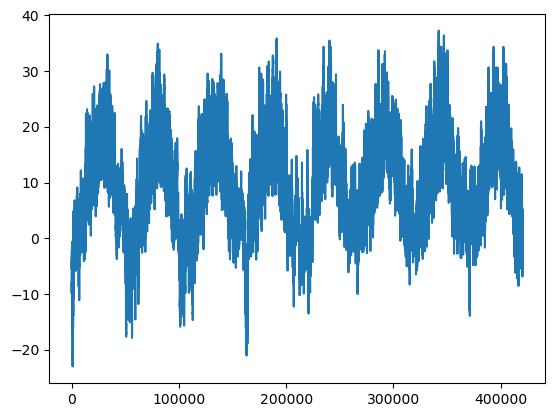

In [4]:
#get the temperature
temp = float_data[:,1]
plt.plot(range(len(temp)),temp)

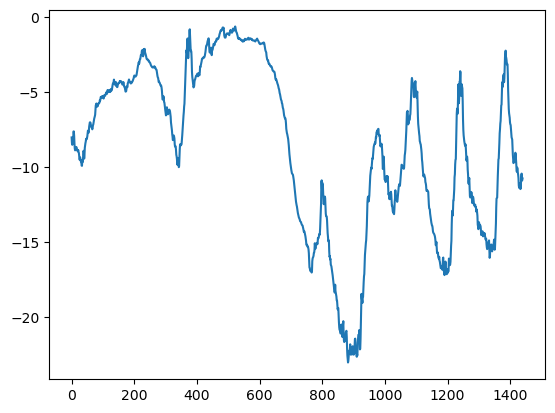

In [5]:
#take a closer look at the temperature data
plt.plot(range(1440),temp[:1440])

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
#create a data generator to seperate data into train and test
def get_train_test(data, split_percent=0.8):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

In [8]:
#see the train and test dataset
train_data, test_data, data = get_train_test(float_data)

print(train_data.shape)
print(test_data.shape)

(4709051,)
(1177263,)


In [9]:
#get the data partition with steps for both train and test datset
def get_XY(dat, time_steps,plot_data_partition=False):
    global X_ind,X,Y_ind,Y #use for plotting later

    # INDICES OF TARGET ARRAY
    # Y_ind [  12   24   36   48 ..]; print(np.arange(1,12,1)); exit()
    Y_ind = np.arange(time_steps, len(dat), time_steps); #print(Y_ind); exit()
    Y = dat[Y_ind]

    # PREPARE X
    rows_x = len(Y)
    X_ind=[*range(time_steps*rows_x)]
    del X_ind[::time_steps] #if time_steps=10 remove every 10th entry
    X = dat[X_ind]; 

    #PLOT
    if(plot_data_partition):
        plt.figure(figsize=(15, 6), dpi=80)
        plt.plot(Y_ind, Y,'o',X_ind, X,'-'); plt.show(); 

    #RESHAPE INTO KERAS FORMAT
    X1 = np.reshape(X, (rows_x, time_steps-1, 1))
    # print([*X_ind]); print(X1); print(X1.shape,Y.shape); exit()

    return X1, Y

In [10]:
p=10 
testX, testY = get_XY(test_data, p)
trainX, trainY = get_XY(train_data, p)

In [11]:
#set some basic hyperparameters
recurrent_hidden_units=3
epochs=60
f_batch=0.2
optimizer="RMSprop"
validation_split=0.2
print(trainX.shape,p,trainY.shape)

print(p,trainX.shape,testX.shape,trainY.shape,testY.shape)

(470905, 9, 1) 10 (470905,)
10 (470905, 9, 1) (117726, 9, 1) (470905,) (117726,)


In [12]:
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM, SimpleRNN, GRU, Dense
from keras.optimizers import RMSprop
from keras import regularizers

2023-04-28 19:56:12.463005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
#use LSTM to predict the test targets
model = Sequential()
model.add(LSTM(
recurrent_hidden_units,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
# recurrent_dropout=0.8,
recurrent_regularizer=regularizers.L2(1e-1),
activation='tanh')
          ) 
     
#NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, activation='linear'))

# COMPILE THE MODEL 
model.compile(loss='mse', optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3)                 60        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


2023-04-28 19:56:15.105592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-28 19:56:15.107365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-28 19:56:15.109242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
history = model.fit(
trainX, trainY, 
epochs=30, 
batch_size=int(f_batch*trainX.shape[0]), 
validation_split=validation_split,  # BEING "SLOPPY WITH CROSS VALIDATION" HERE FOR TIME-SERIES
verbose=2)

Epoch 1/30


2023-04-28 19:56:15.454276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-28 19:56:15.456662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-28 19:56:15.458371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 - 2s - loss: 0.6073 - val_loss: 0.5822 - 2s/epoch - 474ms/step
Epoch 2/30


2023-04-28 19:56:16.970582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-28 19:56:16.971488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-28 19:56:16.973068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 - 0s - loss: 0.5668 - val_loss: 0.5517 - 312ms/epoch - 78ms/step
Epoch 3/30
4/4 - 0s - loss: 0.5391 - val_loss: 0.5268 - 322ms/epoch - 80ms/step
Epoch 4/30
4/4 - 0s - loss: 0.5158 - val_loss: 0.5049 - 385ms/epoch - 96ms/step
Epoch 5/30
4/4 - 0s - loss: 0.4949 - val_loss: 0.4848 - 343ms/epoch - 86ms/step
Epoch 6/30
4/4 - 0s - loss: 0.4755 - val_loss: 0.4660 - 365ms/epoch - 91ms/step
Epoch 7/30
4/4 - 0s - loss: 0.4573 - val_loss: 0.4482 - 412ms/epoch - 103ms/step
Epoch 8/30
4/4 - 0s - loss: 0.4401 - val_loss: 0.4312 - 382ms/epoch - 95ms/step
Epoch 9/30
4/4 - 0s - loss: 0.4236 - val_loss: 0.4149 - 378ms/epoch - 94ms/step
Epoch 10/30
4/4 - 0s - loss: 0.4078 - val_loss: 0.3993 - 409ms/epoch - 102ms/step
Epoch 11/30
4/4 - 0s - loss: 0.3926 - val_loss: 0.3843 - 416ms/epoch - 104ms/step
Epoch 12/30
4/4 - 0s - loss: 0.3781 - val_loss: 0.3700 - 444ms/epoch - 111ms/step
Epoch 13/30
4/4 - 0s - loss: 0.3641 - val_loss: 0.3562 - 442ms/epoch - 110ms/step
Epoch 14/30
4/4 - 0s - loss: 0.3508 - val_

Text(0.5, 1.0, 'Training and validation loss')

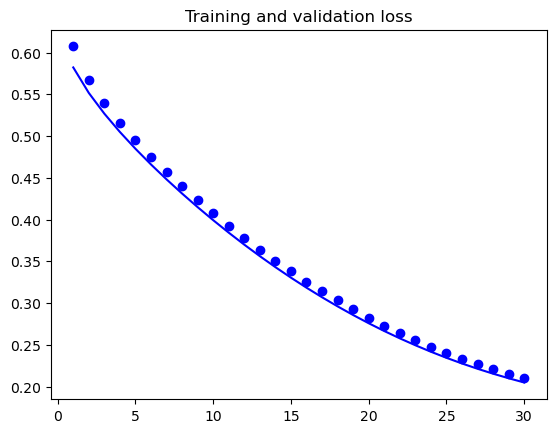

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

In [16]:
#build a simple dense model to analyze the data
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(SimpleRNN(recurrent_hidden_units,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
recurrent_regularizer=regularizers.L2(1e-1),
activation='relu'))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1,activation='linear'))
model.compile(optimizer=optimizer,loss='mae')
history = model.fit(
trainX, trainY, epochs=30, batch_size=int(f_batch*trainX.shape[0]), 
validation_split=validation_split,  # BEING "SLOPPY WITH CROSS VALIDATION" HERE FOR TIME-SERIES
verbose=2)


Epoch 1/30
4/4 - 1s - loss: 0.6168 - val_loss: 0.5512 - 905ms/epoch - 226ms/step
Epoch 2/30
4/4 - 0s - loss: 0.5341 - val_loss: 0.5118 - 172ms/epoch - 43ms/step
Epoch 3/30
4/4 - 0s - loss: 0.5057 - val_loss: 0.4938 - 158ms/epoch - 40ms/step
Epoch 4/30
4/4 - 0s - loss: 0.4910 - val_loss: 0.4813 - 172ms/epoch - 43ms/step
Epoch 5/30
4/4 - 0s - loss: 0.4800 - val_loss: 0.4706 - 148ms/epoch - 37ms/step
Epoch 6/30
4/4 - 0s - loss: 0.4700 - val_loss: 0.4607 - 168ms/epoch - 42ms/step
Epoch 7/30
4/4 - 0s - loss: 0.4607 - val_loss: 0.4513 - 173ms/epoch - 43ms/step
Epoch 8/30
4/4 - 0s - loss: 0.4518 - val_loss: 0.4425 - 178ms/epoch - 44ms/step
Epoch 9/30
4/4 - 0s - loss: 0.4434 - val_loss: 0.4345 - 163ms/epoch - 41ms/step
Epoch 10/30
4/4 - 0s - loss: 0.4358 - val_loss: 0.4274 - 127ms/epoch - 32ms/step
Epoch 11/30
4/4 - 0s - loss: 0.4290 - val_loss: 0.4210 - 128ms/epoch - 32ms/step
Epoch 12/30
4/4 - 0s - loss: 0.4230 - val_loss: 0.4152 - 155ms/epoch - 39ms/step
Epoch 13/30
4/4 - 0s - loss: 0.4174 

Text(0.5, 1.0, 'Training and validation loss')

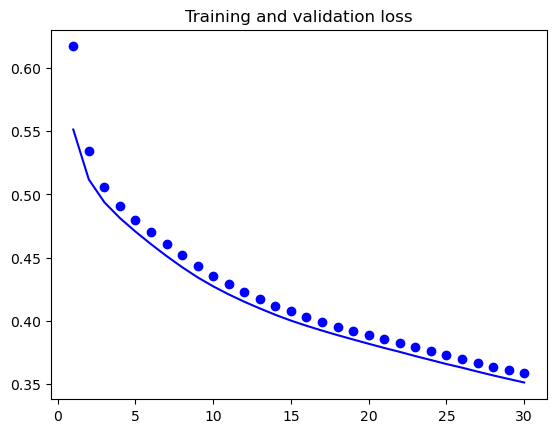

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

In [18]:
#build a basic GRU model to analyze the data
model = Sequential()
model.add(layers.GRU(recurrent_hidden_units,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
recurrent_regularizer=regularizers.L2(1e-1),
activation='relu'))
model.add(layers.Dense(1,activation='linear'))

model.compile(optimizer=optimizer,loss='mae')
history = model.fit(
trainX, trainY, epochs=30, batch_size=int(f_batch*trainX.shape[0]), 
validation_split=validation_split,  # BEING "SLOPPY WITH CROSS VALIDATION" HERE FOR TIME-SERIES
verbose=2)

Epoch 1/30
4/4 - 1s - loss: 0.6394 - val_loss: 0.6176 - 1s/epoch - 303ms/step
Epoch 2/30
4/4 - 0s - loss: 0.6052 - val_loss: 0.5913 - 330ms/epoch - 83ms/step
Epoch 3/30
4/4 - 0s - loss: 0.5819 - val_loss: 0.5700 - 333ms/epoch - 83ms/step
Epoch 4/30
4/4 - 0s - loss: 0.5625 - val_loss: 0.5514 - 357ms/epoch - 89ms/step
Epoch 5/30
4/4 - 0s - loss: 0.5452 - val_loss: 0.5345 - 326ms/epoch - 82ms/step
Epoch 6/30
4/4 - 0s - loss: 0.5295 - val_loss: 0.5190 - 326ms/epoch - 82ms/step
Epoch 7/30
4/4 - 0s - loss: 0.5148 - val_loss: 0.5045 - 367ms/epoch - 92ms/step
Epoch 8/30
4/4 - 0s - loss: 0.5011 - val_loss: 0.4909 - 344ms/epoch - 86ms/step
Epoch 9/30
4/4 - 0s - loss: 0.4881 - val_loss: 0.4781 - 342ms/epoch - 85ms/step
Epoch 10/30
4/4 - 0s - loss: 0.4759 - val_loss: 0.4659 - 361ms/epoch - 90ms/step
Epoch 11/30
4/4 - 0s - loss: 0.4643 - val_loss: 0.4544 - 389ms/epoch - 97ms/step
Epoch 12/30
4/4 - 0s - loss: 0.4533 - val_loss: 0.4434 - 470ms/epoch - 117ms/step
Epoch 13/30
4/4 - 0s - loss: 0.4429 - 

Text(0.5, 1.0, 'Training and validation loss')

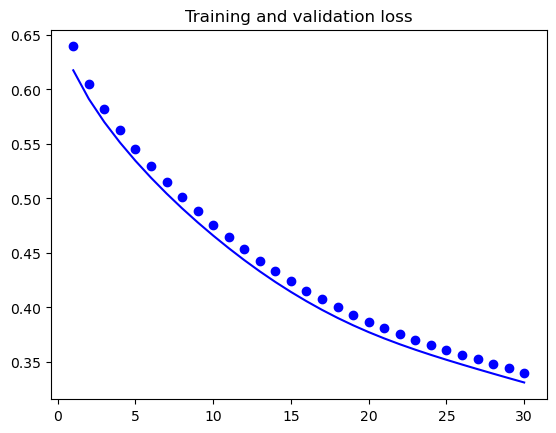

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

In [20]:
#build a GRU model with recurrent_dropout to analyze the data
model = Sequential()
model.add(layers.GRU(recurrent_hidden_units,
recurrent_dropout=0.8,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
recurrent_regularizer=regularizers.L2(1e-1),
activation='relu'))
model.add(layers.Dense(1,activation='linear'))

model.compile(optimizer=optimizer,loss='mae')
history = model.fit(
trainX, trainY, epochs=30, batch_size=int(f_batch*trainX.shape[0]), 
validation_split=validation_split,  # BEING "SLOPPY WITH CROSS VALIDATION" HERE FOR TIME-SERIES
verbose=2)

Epoch 1/30
4/4 - 2s - loss: 0.9121 - val_loss: 0.9007 - 2s/epoch - 432ms/step
Epoch 2/30
4/4 - 0s - loss: 0.8775 - val_loss: 0.8729 - 419ms/epoch - 105ms/step
Epoch 3/30
4/4 - 0s - loss: 0.8532 - val_loss: 0.8497 - 388ms/epoch - 97ms/step
Epoch 4/30
4/4 - 0s - loss: 0.8324 - val_loss: 0.8288 - 409ms/epoch - 102ms/step
Epoch 5/30
4/4 - 0s - loss: 0.8134 - val_loss: 0.8092 - 427ms/epoch - 107ms/step
Epoch 6/30
4/4 - 0s - loss: 0.7956 - val_loss: 0.7905 - 400ms/epoch - 100ms/step
Epoch 7/30
4/4 - 0s - loss: 0.7785 - val_loss: 0.7725 - 448ms/epoch - 112ms/step
Epoch 8/30
4/4 - 0s - loss: 0.7620 - val_loss: 0.7550 - 403ms/epoch - 101ms/step
Epoch 9/30
4/4 - 0s - loss: 0.7459 - val_loss: 0.7380 - 410ms/epoch - 102ms/step
Epoch 10/30
4/4 - 0s - loss: 0.7303 - val_loss: 0.7214 - 404ms/epoch - 101ms/step
Epoch 11/30
4/4 - 0s - loss: 0.7150 - val_loss: 0.7052 - 437ms/epoch - 109ms/step
Epoch 12/30
4/4 - 0s - loss: 0.7000 - val_loss: 0.6893 - 443ms/epoch - 111ms/step
Epoch 13/30
4/4 - 0s - loss: 

Text(0.5, 1.0, 'Training and validation loss')

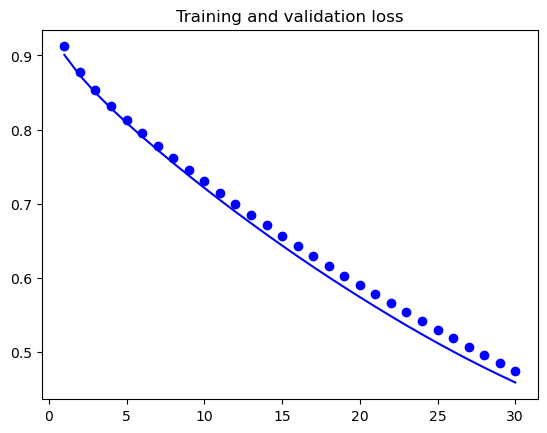

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

In [22]:
#build a model with both dropout and recurrent_dropout to analyze the data
model = Sequential()
model.add(layers.GRU(recurrent_hidden_units,
                     dropout=0.1,
recurrent_dropout=0.8,
return_sequences=False,
input_shape=(trainX.shape[1],trainX.shape[2]), 
recurrent_regularizer=regularizers.L2(1e-1),
activation='relu'))
model.add(layers.Dense(1,activation='linear'))

model.compile(optimizer=optimizer,loss='mae')
history = model.fit(
trainX, trainY, epochs=30, batch_size=int(f_batch*trainX.shape[0]), 
validation_split=validation_split,  # BEING "SLOPPY WITH CROSS VALIDATION" HERE FOR TIME-SERIES
verbose=2)

Epoch 1/30
4/4 - 2s - loss: 0.7653 - val_loss: 0.7550 - 2s/epoch - 450ms/step
Epoch 2/30
4/4 - 0s - loss: 0.7433 - val_loss: 0.7382 - 408ms/epoch - 102ms/step
Epoch 3/30
4/4 - 0s - loss: 0.7280 - val_loss: 0.7245 - 449ms/epoch - 112ms/step
Epoch 4/30
4/4 - 0s - loss: 0.7149 - val_loss: 0.7121 - 422ms/epoch - 105ms/step
Epoch 5/30
4/4 - 0s - loss: 0.7031 - val_loss: 0.7007 - 417ms/epoch - 104ms/step
Epoch 6/30
4/4 - 0s - loss: 0.6919 - val_loss: 0.6899 - 447ms/epoch - 112ms/step
Epoch 7/30
4/4 - 0s - loss: 0.6813 - val_loss: 0.6796 - 423ms/epoch - 106ms/step
Epoch 8/30
4/4 - 0s - loss: 0.6712 - val_loss: 0.6698 - 452ms/epoch - 113ms/step
Epoch 9/30
4/4 - 0s - loss: 0.6615 - val_loss: 0.6604 - 446ms/epoch - 111ms/step
Epoch 10/30
4/4 - 0s - loss: 0.6521 - val_loss: 0.6512 - 394ms/epoch - 99ms/step
Epoch 11/30
4/4 - 0s - loss: 0.6430 - val_loss: 0.6423 - 412ms/epoch - 103ms/step
Epoch 12/30
4/4 - 0s - loss: 0.6341 - val_loss: 0.6336 - 483ms/epoch - 121ms/step
Epoch 13/30
4/4 - 0s - loss: 

Text(0.5, 1.0, 'Training and validation loss')

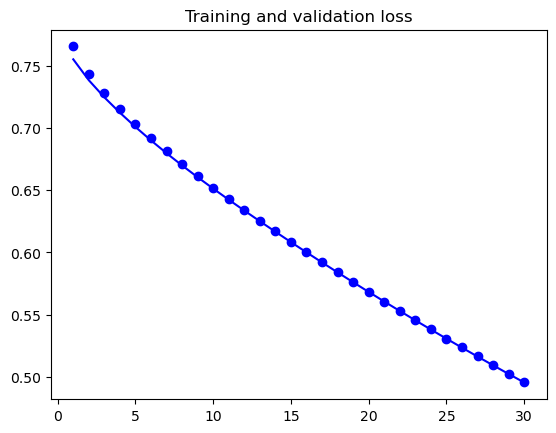

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')